# imports

In [1]:
import torch
from transformers import DataCollatorWithPadding, DistilBertTokenizer, pipeline, \
                    DistilBertForSequenceClassification, TrainingArguments, Trainer, \
                    DistilBertTokenizerFast
from datasets import Dataset

import numpy as np
import pandas as pd
import math
from pynvml import *

import evaluate
accuracy = evaluate.load("accuracy")
from sklearn.metrics import confusion_matrix

from accelerate import Accelerator
accelerator = Accelerator()
import gc

import matplotlib.pyplot as plt
import seaborn as sn
from IPython.display import clear_output

import contractions
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
import re
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/connor/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Functions

In [2]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

def build_confusion(y_true, y_pred, classes):
    cf_matrix = confusion_matrix(y_true, y_pred)
    make_confusion_matrix(cf_matrix, categories=classes, figsize=(8,6), cbar=False)

def eval_model(test_rows, classifier, id2label, token_max):
    tokenizer_args= {'truncation':True, 'max_length':token_max, 'padding':True}
    y_pred = []
    y_true = []
    for _, row in test_rows.iterrows():
        y_pred.append(classifier(row['text'], **tokenizer_args)[0]['label'])
        y_true.append(id2label[row['label']])  
    return y_true, y_pred

def eval_example(example, tokenizer_args, classifier):
    val = classifier(example, **tokenizer_args)
    return val

def calc_accuracy(y_true,y_pred):
    accuracy = 0
    for x in range(len(y_true)):
        if y_pred[x]==y_true[x]:
            accuracy+=1
    print(f'Accuracy: {(accuracy/len(y_true))*100:.2f}%')
    
def make_confusion_matrix(cf,
                          categories='auto',
                          cbar=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    
    group_labels = ['' for i in range(cf.size)]
    group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])

    accuracy  = np.trace(cf) / float(np.sum(cf))
    stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    
    if figsize==None:
        figsize = plt.rcParams.get('figure.figsize')

    plt.figure(figsize=figsize)
    sn.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    plt.ylabel('True label')
    plt.xlabel('Predicted label' + stats_text)
    if title:
        plt.title(title)

def print_GPU():
    nvmlInit()
    handle = nvmlDeviceGetHandleByIndex(0)
    info = nvmlDeviceGetMemoryInfo(handle)
    print(f"GPU memory occupied: {info.used//1024**2} MB.")

def format_rows_for_train(df, label2id, preprocess_text=None):
    newdf = df.loc[df['label'].notnull()].copy()
    if preprocess_text:
        newdf['description'] = newdf['description'].apply(lambda x: preprocess_text(x))
    
    newdf['text'] = newdf[['title', 'description']].apply(lambda x: f"title {x['title'].lower()} description {x['description']}", axis=1)
    newdf['label'] = newdf['label'].apply(lambda x: label2id[x])
    
    final_df = newdf[['text','label']].copy()
    training_rows_DS = Dataset.from_pandas(final_df)
    training_rows_DS = training_rows_DS.train_test_split(train_size=.8, seed=42) 

    train_rows = pd.DataFrame(list(zip(training_rows_DS['train']['text'], training_rows_DS['train']['label'])), columns =['text','label'])
    test_rows = pd.DataFrame(list(zip(training_rows_DS['test']['text'], training_rows_DS['test']['label'])), columns =['text','label'])
    
    return training_rows_DS, train_rows, test_rows

def print_label_counts(split_datasets, label_column='label'):
    for split in ['train', 'test']:
        dataset = split_datasets[split] 
        labels = dataset[label_column]  
        
        if isinstance(labels, pd.Series):
            label_counts = labels.value_counts()
        else:
            label_counts = pd.Series(labels).value_counts()
        
        print(f"Label counts for {split} set:")
        print_string = ''
        for idx,[key,value] in enumerate(label_counts.items()):
            print_string += f"{key}: {value} "
            if idx != len(label_counts.keys())-1:
                print_string += "| "
            
        print(print_string)

def preprocess_text(text):
    text = text.lower()
    text = contractions.fix(text)
    text = text.replace('(','')
    text = text.replace(')','')
    text = re.sub(r'https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,}', 'URL', text)
    text = ' '.join([word for word in text.split() if word not in stop_words])
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Model function

In [3]:
def run_model_v9(train_rows, test_rows, tokenizer, tokenizer_config, epochs, train_batch, test_batch, base_model, out_put_dir, compute_metrics, id2label, label2id,  should_return=False):
    
    def preprocess(examples):  
        return tokenizer(examples['text'], **tokenizer_config)

    train_rows_DS = Dataset.from_pandas(train_rows)
    test_rows_DS = Dataset.from_pandas(test_rows)
        
    train_rows_DS = train_rows_DS.map(preprocess, batched=True)
    test_rows_DS = test_rows_DS.map(preprocess, batched=True)
    
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")
    
    # base_model = accelerator.prepare(base_model)
    
    training_args = TrainingArguments(
        output_dir=out_put_dir,
        overwrite_output_dir=True, 
        num_train_epochs=epochs, 
        per_device_train_batch_size=train_batch, 
        per_device_eval_batch_size=test_batch,  
        load_best_model_at_end=True,
        logging_steps=5,
        log_level='info',
        evaluation_strategy='epoch',
        save_strategy='epoch'
    )

    trainer = Trainer(
        model=base_model,
        args=training_args,
        train_dataset=train_rows_DS,
        eval_dataset=test_rows_DS,
        data_collator=data_collator,
        compute_metrics=compute_metrics
    )
    
    eval_results_before = trainer.evaluate()
    
    train_results = trainer.train()
    
    eval_results_after = trainer.evaluate()
    
    trainer.save_model()
    
    classifier = pipeline('text-classification', model=out_put_dir, tokenizer=tokenizer, device=0)
    
    y_true, y_pred = eval_model(test_rows, classifier, id2label, tokenizer_config['max_length'])
    
    
    print(f'Eval Model before train')
    print(f"Accuracy: {(eval_results_before['eval_accuracy'])*100:.2f}%, Loss: {eval_results_before['eval_loss']:.2f}, Time: {eval_results_before['eval_runtime']}")
    print(f'Eval Model After train')
    print(f"Accuracy: {(eval_results_after['eval_accuracy'])*100:.2f}%, Loss: {eval_results_after['eval_loss']:.2f}, Time: {eval_results_after['eval_runtime']}")
        
    build_confusion(y_true, y_pred, label2id.keys())
    

    del trainer, classifier
    gc.collect()
    torch.cuda.empty_cache()
    
    if should_return:
        return ((eval_results_after['eval_accuracy'])*100)

# Configs

In [4]:
max_length=512
out_put_dir = f"./jobLevel_bert"
id2label = {0: "technology", 1: "other"}
label2id = {"technology":0, "other": 1}
tokenizer_config = {'max_length': max_length,
                    'truncation': True,
                    'padding': True}

train_batch = 4
test_batch = 4
epochs = 5

tokenizer_funct = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

## Base Model Load

In [5]:
base_model = DistilBertForSequenceClassification.from_pretrained(
        "distilbert-base-uncased", num_labels=len(id2label.keys()), id2label=id2label, label2id=label2id
    ).cuda()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'pre_classifi

# Model Train

In [6]:
train_df = pd.read_csv('MASTER_DF.csv')
train_df

,Unnamed: 0,id,title,description,company,raw_location,label,labeledby
0,0,greenhouse::poppulo::5318176,Chief Product Officer,Are you searching for an opportunity to play a...,poppulo,"US, Ireland - Hybrid/Remote",technology,hand
1,1,greenhouse::poppulo::5579563,Senior Information Security Engineer,Introduction Are you searching for an opportu...,poppulo,Bengaluru-Hybrid,technology,hand
2,2,greenhouse::poppulo::5531610,Customer Data Analyst,Introduction Are you searching for an opportun...,poppulo,Bengaluru-Hybrid,technology,hand
3,3,greenhouse::sandstonecare::5779797,Admissions Specialist,Position Title: Admissions Coordinator Schedul...,sandstonecare,"Denver, Colorado",technology,hand
4,4,greenhouse::samsungresearchamerica::7061556002,"Senior Staff, Research Engineer-Generative AI",Lab Summary: We are an interdisciplinary team...,samsungresearchamerica,"665 Clyde Avenue, Mountain View, CA, USA",technology,hand
...,...,...,...,...,...,...,...,...
19505,19505,greenhouse::rise8::4295121007,Cleared Senior Product Manager,Your Dream. Our Team. About Rise8 Were transfo...,rise8,"Colorado Springs, CO (Hybrid)",NaN,NaN
19506,19506,greenhouse::sanityio::5871260003,"Senior Product Designer, Growth",Were looking for a creative and data-driven Se...,sanityio,"Oslo, Oslo, Norway, New York, United States",NaN,NaN
19507,19507,greenhouse::sanityio::5873474003,"Director, Revenue Operations",We are looking for an experienced Director of ...,sanityio,Remote in the United States,NaN,NaN
19508,19508,greenhouse::sanityio::5785780003,Principal Product Marketing Manager,Were searching for an influential Principal Pr...,sanityio,Remote in the United States,NaN,NaN


Label counts for train set:
1: 281 | 0: 115 
Label counts for test set:
1: 75 | 0: 25 


Map:   0%|          | 0/396 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 100
  Batch size = 4
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/home/connor/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 396
  Num Epochs = 5
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 495
  Number of trainable parameters = 66955010


Epoch,Training Loss,Validation Loss,Accuracy
1,0.247800,0.030418,0.990000
2,0.001200,0.004075,1.000000
3,0.032500,0.000538,1.000000
4,0.000500,0.002566,1.000000
5,0.000400,0.002740,1.000000


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 100
  Batch size = 4
Saving model checkpoint to ./jobLevel_bert/checkpoint-99
Configuration saved in ./jobLevel_bert/checkpoint-99/config.json
Model weights saved in ./jobLevel_bert/checkpoint-99/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 100
  Batch size = 4
Saving model checkpoint to ./jobLevel_bert/checkpoint-198
Configuration saved in ./jobLevel_bert/checkpoint-198/config.json
Model

Saving model checkpoint to ./jobLevel_bert
Configuration saved in ./jobLevel_bert/config.json
Model weights saved in ./jobLevel_bert/pytorch_model.bin
loading configuration file ./jobLevel_bert/config.json
Model config DistilBertConfig {
  "_name_or_path": "./jobLevel_bert",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "technology",
    "1": "other"
  },
  "initializer_range": 0.02,
  "label2id": {
    "other": 1,
    "technology": 0
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

loading configuration file ./jobLevel_

Eval Model before train
Accuracy: 75.00%, Loss: 0.65, Time: 1.2918
Eval Model After train
Accuracy: 100.00%, Loss: 0.00, Time: 0.7818


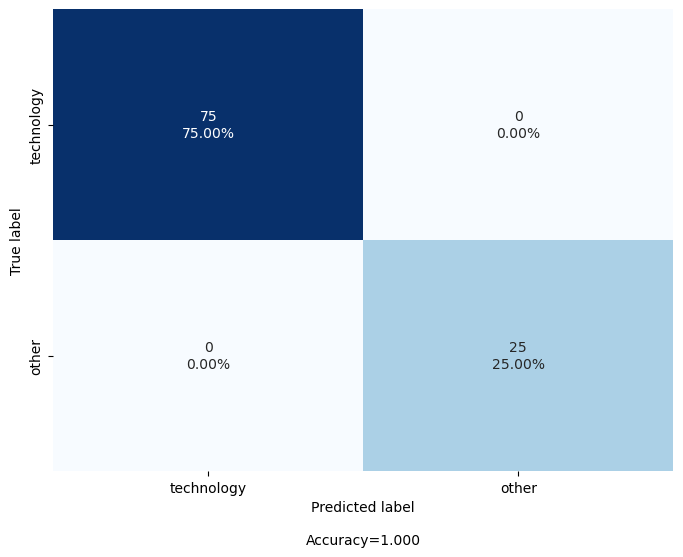

In [8]:
training_rows_DS, train_rows, test_rows = format_rows_for_train(train_df, label2id, preprocess_text=None)
print_label_counts(training_rows_DS)
accuracy_metric = run_model_v9(train_rows, test_rows, tokenizer_funct, tokenizer_config, epochs, train_batch, test_batch, base_model, out_put_dir, compute_metrics, id2label, label2id,  True)

del base_model
gc.collect()
torch.cuda.empty_cache()

# Load Existing 

In [9]:
existing_model = pipeline('text-classification', model=out_put_dir, tokenizer=tokenizer_funct, device=0)

loading configuration file ./jobLevel_bert/config.json
Model config DistilBertConfig {
  "_name_or_path": "./jobLevel_bert",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "technology",
    "1": "other"
  },
  "initializer_range": 0.02,
  "label2id": {
    "other": 1,
    "technology": 0
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

loading configuration file ./jobLevel_bert/config.json
Model config DistilBertConfig {
  "_name_or_path": "./jobLevel_bert",
  "activation": "gelu",
  "architectures": [
    "DistilBertForS

# Label Data with Model predict

In [47]:
def label_new_data(df, num_examples: int, eval_example_funct, tokenizer_args, classifier):
    should_break_loop = False
    num_labeled = 0
    for row_count, row in df.iterrows():
        if pd.isna(row['label']):
            text = f"title {row['title']} description {preprocess_text(row['description'])}"

            result = eval_example_funct(text, tokenizer_args, classifier)[0]

            print(f"{row['title']}")
            print(f"{row['description']}")
            print(f"{row['id']} - {result['label']}: {result['score']*100:.2f}%")

            while True:
                num_labeled +=1
                user_input = input("Is label Correct? F for yes. J For No. P Escape")
                user_input = user_input.lower() 
                if user_input in ['f','j','p']:
                    if user_input == 'p':
                        should_break_loop = True
                        break
                    elif user_input == 'f': 
                        row['label'] = result['label']
                        row['labeledby']='model'
                        break
                    elif user_input == 'j': 
                        if result['label'] == "technology":
                            row['label'] = "other"
                        else:
                            row['label'] = "technology"
                        
                        row['labeledby']='hand'
                        break

            clear_output()
            if should_break_loop or num_labeled == num_examples:
                break

# Data load

In [43]:
label_df = pd.read_csv('MASTER_DF.csv', index_col=0)
label_df

,id,title,description,company,raw_location,label,labeledby
0,greenhouse::poppulo::5318176,Chief Product Officer,Are you searching for an opportunity to play a...,poppulo,"US, Ireland - Hybrid/Remote",technology,hand
1,greenhouse::poppulo::5579563,Senior Information Security Engineer,Introduction Are you searching for an opportu...,poppulo,Bengaluru-Hybrid,technology,hand
2,greenhouse::poppulo::5531610,Customer Data Analyst,Introduction Are you searching for an opportun...,poppulo,Bengaluru-Hybrid,technology,hand
3,greenhouse::sandstonecare::5779797,Admissions Specialist,Position Title: Admissions Coordinator Schedul...,sandstonecare,"Denver, Colorado",technology,hand
4,greenhouse::samsungresearchamerica::7061556002,"Senior Staff, Research Engineer-Generative AI",Lab Summary: We are an interdisciplinary team...,samsungresearchamerica,"665 Clyde Avenue, Mountain View, CA, USA",technology,hand
...,...,...,...,...,...,...,...
19505,greenhouse::rise8::4295121007,Cleared Senior Product Manager,Your Dream. Our Team. About Rise8 Were transfo...,rise8,"Colorado Springs, CO (Hybrid)",NaN,NaN
19506,greenhouse::sanityio::5871260003,"Senior Product Designer, Growth",Were looking for a creative and data-driven Se...,sanityio,"Oslo, Oslo, Norway, New York, United States",NaN,NaN
19507,greenhouse::sanityio::5873474003,"Director, Revenue Operations",We are looking for an experienced Director of ...,sanityio,Remote in the United States,NaN,NaN
19508,greenhouse::sanityio::5785780003,Principal Product Marketing Manager,Were searching for an influential Principal Pr...,sanityio,Remote in the United States,NaN,NaN


In [44]:
label_df[506:520]

,id,title,description,company,raw_location,label,labeledby
506,greenhouse::sandstonecascade::5723701,Overnight Mental Health Technician,Position Title: Night Shift Mental Health Tech...,sandstonecascade,"Sandstone Care - Cascade, Colorado",other,hand
507,greenhouse::rbicareers::7255716002,"Manager, Construction, FHS, US Central",About Restaurant Brands International: Restaur...,rbicareers,"Houston, TX",NaN,NaN
508,greenhouse::rbicareers::7085066002,"Director, Operations, BK, Canada",About Restaurant Brands International: Restaur...,rbicareers,"Toronto, ON, Canada",NaN,NaN
509,greenhouse::rbicareers::7276088002,"Manager, Catering, Popeyes Louisiana Kitchen, ...",About Restaurant Brands International: Restaur...,rbicareers,"Miami, FL",NaN,NaN
510,greenhouse::rbicareers::7046338002,"Manager, Equity Compensation",About Restaurant Brands International: Restaur...,rbicareers,"Miami, FL",NaN,NaN
511,greenhouse::rbicareers::7181362002,"Manager, Field Marketing, Tim Hortons & Fireho...",About Restaurant Brands International: Restaur...,rbicareers,"Miami, FL",NaN,NaN
512,greenhouse::rbicareers::7120411002,"Manager, Construction, FHS, US Southeast",About Restaurant Brands International: Restaur...,rbicareers,"Jacksonville, FL",NaN,NaN
513,greenhouse::rbicareers::7282453002,"Director, Culinary Innovation Chef, Burger Kin...",About Restaurant Brands International: Restaur...,rbicareers,"Miami, FL",NaN,NaN
514,greenhouse::rbicareers::7268550002,"Operations Partner, BK, US Southeast",About Restaurant Brands International: Restaur...,rbicareers,"Montgomery, AL",NaN,NaN
515,greenhouse::rbicareers::7082569002,"Manager, Franchise Performance, TH, Canada Cen...",About Restaurant Brands International: Restaur...,rbicareers,"Toronto, ON, Canada",NaN,NaN


# Labeling

In [54]:
num_labeled_before = len(label_df.loc[label_df['label'].notnull()])
print(num_labeled_before)

506


In [50]:
label_new_data(label_df, 5, eval_example, tokenizer_config, existing_model)

In [55]:
num_labeled_after = len(label_df.loc[label_df['label'].notnull()])
print(num_labeled_after)

506


# Data Explore

In [52]:
e_df = pd.read_csv('MASTER_DF.csv', index_col=0)

In [50]:
e_df

,id,title,description,company,raw_location,label,labeledby
0,greenhouse::poppulo::5318176,Chief Product Officer,Are you searching for an opportunity to play a...,poppulo,"US, Ireland - Hybrid/Remote",technology,hand
1,greenhouse::poppulo::5579563,Senior Information Security Engineer,Introduction Are you searching for an opportu...,poppulo,Bengaluru-Hybrid,technology,hand
2,greenhouse::poppulo::5531610,Customer Data Analyst,Introduction Are you searching for an opportun...,poppulo,Bengaluru-Hybrid,technology,hand
3,greenhouse::sandstonecare::5779797,Admissions Specialist,Position Title: Admissions Coordinator Schedul...,sandstonecare,"Denver, Colorado",technology,hand
4,greenhouse::samsungresearchamerica::7061556002,"Senior Staff, Research Engineer-Generative AI",Lab Summary: We are an interdisciplinary team...,samsungresearchamerica,"665 Clyde Avenue, Mountain View, CA, USA",technology,hand
...,...,...,...,...,...,...,...
19505,greenhouse::rise8::4295121007,Cleared Senior Product Manager,Your Dream. Our Team. About Rise8 Were transfo...,rise8,"Colorado Springs, CO (Hybrid)",NaN,NaN
19506,greenhouse::sanityio::5871260003,"Senior Product Designer, Growth",Were looking for a creative and data-driven Se...,sanityio,"Oslo, Oslo, Norway, New York, United States",NaN,NaN
19507,greenhouse::sanityio::5873474003,"Director, Revenue Operations",We are looking for an experienced Director of ...,sanityio,Remote in the United States,NaN,NaN
19508,greenhouse::sanityio::5785780003,Principal Product Marketing Manager,Were searching for an influential Principal Pr...,sanityio,Remote in the United States,NaN,NaN


In [9]:
null_counts = e_df.isnull().sum()
print(null_counts)

id                  0
title               0
description         0
company             0
raw_location        7
label           19014
labeledby       18995
dtype: int64


In [41]:
def calculate_total_token_count(text, tokenizer_funct):
    encoded_dict = tokenizer_funct.encode_plus(
        text,
        add_special_tokens=True, 
        max_length=512,  
        truncation=True,
        return_overflowing_tokens=True,  
    )
    total_token= 0
    for x in range(len(encoded_dict['input_ids'])):
        total_token += len(encoded_dict['input_ids'][x])
        if x !=0:
            total_token-=2
    
    return total_token


In [53]:
e_df['tk_count_description'] = e_df['description'].apply(lambda x: calculate_total_token_count(x, tokenizer_funct))
e_df['tk_count_title'] = e_df['title'].apply(lambda x: calculate_total_token_count(x.lower(), tokenizer_funct))
e_df['processed_description'] = e_df['description'].apply(lambda x: preprocess_text(x))
e_df['tk_count_pre_description'] = e_df['processed_description'].apply(lambda x: calculate_total_token_count(x, tokenizer_funct))

e_df['fmt_text'] = e_df[['title', 'processed_description']].apply(lambda x: f"title {x['title'].lower()} description {x['processed_description']}", axis=1)

e_df['tk_count_fmt_text'] = e_df['fmt_text'].apply(lambda x: calculate_total_token_count(x, tokenizer_funct))


In [63]:
def describe_df(df):

    mean_token_fmt = df['tk_count_fmt_text'].mean()    
    max_token_fmt = df['tk_count_fmt_text'].max()
    
    mean_token_title = df['tk_count_title'].mean()    
    max_token_title = df['tk_count_title'].max()
    
    mean_token_p_description = df['tk_count_pre_description'].mean()    
    max_token_p_description = df['tk_count_pre_description'].max()
    
    count_fmt_rows_above_max_length = (df['tk_count_fmt_text'] > 512).sum()
    count_title_rows_above_mean = (df['tk_count_title'] > int(mean_token_title)).sum()

    
    
    print(f"Full text: Mean: {mean_token_fmt}, Max: {max_token_fmt}")
    print(f"Title text: Mean: {mean_token_title}, Max: {max_token_title}")
    print(f"Processed Description text: Mean: {mean_token_p_description}, Max: {max_token_p_description}")
    
    print(f"Title above mean title size: {count_title_rows_above_mean}, or {(count_title_rows_above_mean/len(df))*100:.2f}%")
    print(f"Processed Description text above 512: {count_fmt_rows_above_max_length}, or {(count_fmt_rows_above_max_length/len(df))*100:.2f}%")
    
    

In [64]:
describe_df(e_df)

Full text: Mean: 586.9636084059457, Max: 2805
Title text: Mean: 7.881137878011276, Max: 72
Processed Description text: Mean: 579.0824705279344, Max: 2791
Title above mean title size: 8798, or 45.09%
Processed Description text above 512: 11119, or 56.99%
